In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import logging
import os
import pickle
from typing import List, Tuple, Type

import numpy as np
import geopandas as gpd
import rasterio
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

from src.data_loading.rasterio_utils import get_thumbnail
from src.unet.satellite_image import SatelliteImage
from src.unet.dataloader import SatelliteDataset, LabelledSatelliteDataset
from rasterio.plot import reshape_as_raster, reshape_as_image
import xarray as xr

from src.constants import SRC_PATH, GWS_DATA_DIR, WGS84, UTM35N, SENTINEL_DIR
SENTINEL_POLESIA_DIR = SENTINEL_DIR / "Polesia_10m"
SENTINEL_CHERNOBYL_DIR = SENTINEL_DIR / "Chernobyl_10m"

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# 1. Load labels

In [3]:
burned_classes =  GWS_DATA_DIR / "polesia_burned_superclasses_all_touched_10m.tif"

In [4]:
burned_vals = xr.open_rasterio(burned_classes, chunks={"band": 1, "x": 256, "y": 256})

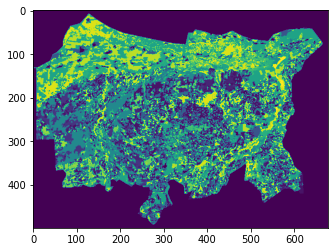

In [5]:
polesia_raster_thumbnail = get_thumbnail(rasterio.open(burned_classes), height=500)
plt.imshow(polesia_raster_thumbnail);

In [6]:
label_array = burned_vals.compute()

In [7]:
# Get fraction of data points:
n_pixels_with_data = np.sum(label_array.data > 0)
total_pixels = np.prod(label_array.shape)

print(f"Percentage of data pixels in mask: {n_pixels_with_data / total_pixels*100:.2f}%")

Percentage of data pixels in mask: 60.01%


# 2. Inspect class imbalance

In [8]:
pixel_counts = [np.sum(label_array.data == i) for i in range(21)]

pixel_occurence =  pixel_counts[1:] / n_pixels_with_data * 100

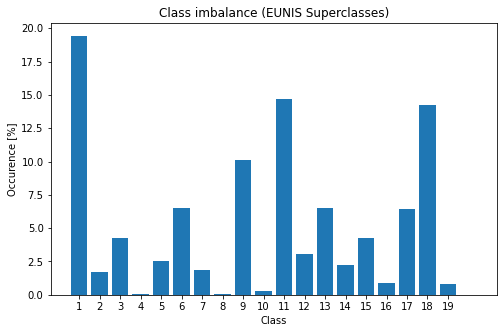

In [9]:
fig = plt.figure(figsize=(8,5))
plt.bar(range(1,21), pixel_occurence) 
plt.xticks(np.arange(1,20), np.arange(1,20))
plt.title("Class imbalance (EUNIS Superclasses)")
plt.ylabel("Occurence [%]")
plt.xlabel("Class");

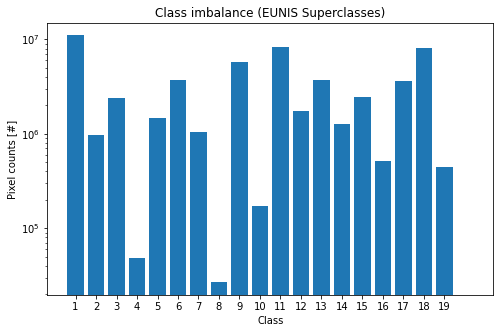

In [10]:
fig = plt.figure(figsize=(8,5))
plt.bar(range(1,21), pixel_counts[1:] ) 
plt.xticks(np.arange(1,20), np.arange(1,20))
plt.title("Class imbalance (EUNIS Superclasses)")
plt.ylabel("Pixel counts [#]")
plt.xlabel("Class")
plt.semilogy();

In [11]:
label_names = {
    0: "No data",
    1: "Pine forest", 
    2: "Reed beds", 
    3: "Undamaged bog",
    4: "Damaged bog",
    5: "Raised bog",
    6: "Scrub woodland",
    7: "Spruce",
    8: "Water",
    9: "Mires",
    10: "Beds of large [Carex] species",
    11: "Agriculture grass",
    12: "Meadows", 
    13: "Swamp woods", 
    14: "Mixed forest 1",
    15: "Felled forest",
    16: "Cropland",
    17: "Urban",
    18: "Mixed forest 2",
    19: "Herb stands"
}

### How are the different classes distributed spatially?

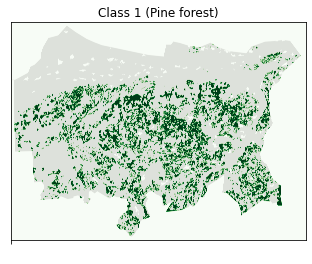

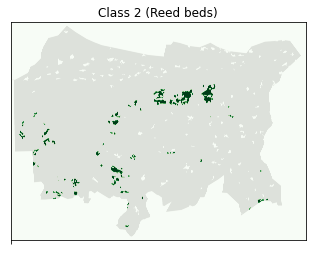

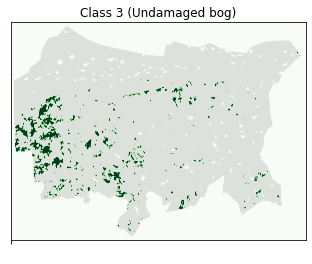

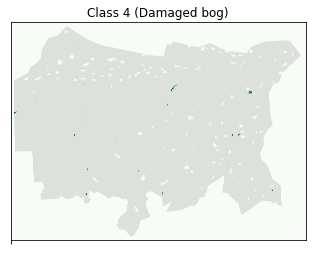

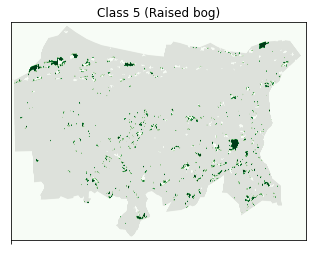

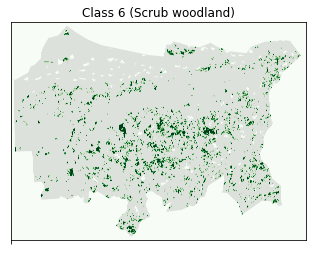

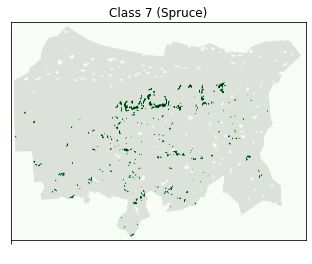

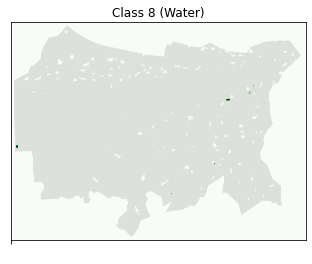

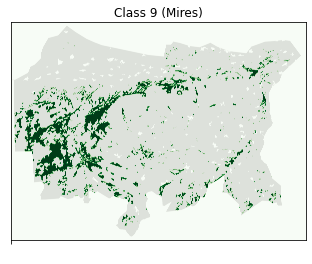

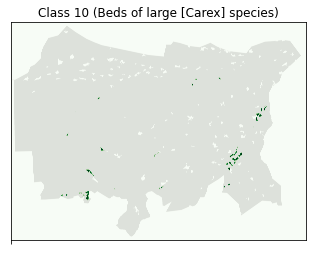

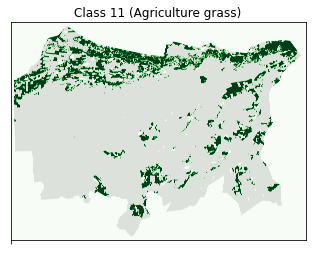

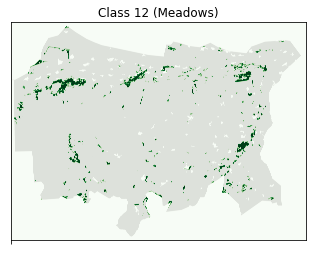

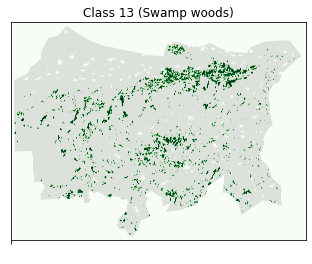

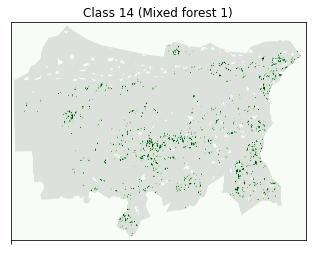

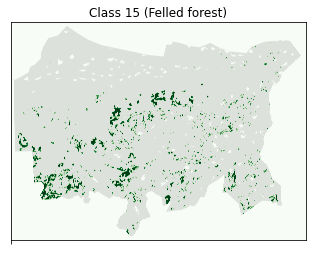

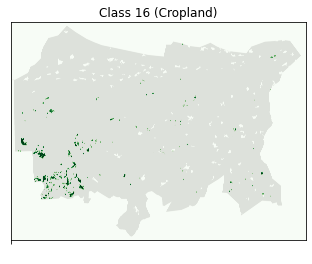

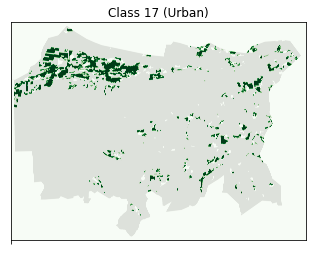

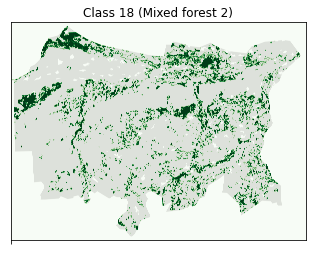

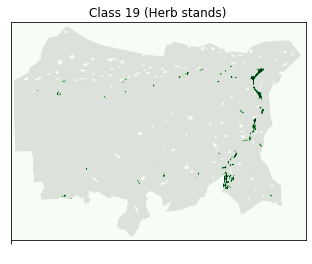

In [63]:
for i in range(1,20):
    plt.imshow(label_array.squeeze() != 0, cmap="Greys")
    plt.imshow(label_array.squeeze() == i, alpha=0.9, cmap="Greens")
    plt.title(f"Class {i} ({label_names[i]})")
    plt.xticks([1], [" "])
    plt.yticks([])
    plt.show()

# 3. Generate train-valid-test split

From an inspection of the spatial distribution of the labels above and a consultation of the expert (Adham) on the region, it seems most sensible to cut data out from the top right diagional for a train-valid-test split.

We will go for a 70-15-15 split.

We'll also choose it in such a way that it perfectly aligns with the tile size of 256, to have a nice split.

In [321]:
from src.constants import SENTINEL_POLESIA_DIR, GWS_DATA_DIR
from src.unet.normalizers import IdentityNormalizer
from src.unet.dataloader import LabelledSatelliteDataset

tile_size = 256
images_path = SENTINEL_POLESIA_DIR / "train"
labels_path = GWS_DATA_DIR / "polesia_burned_superclasses_all_touched_10m.tif"
rgb_bands = [2,1,0]

labelled_dataset = LabelledSatelliteDataset(images_path=images_path,
                                            labels_path=labels_path, 
                                            use_bands=rgb_bands,
                                            tile_size=256,
                                            overlap_threshold=0.00001)

In [360]:
label_mask = label_array.data.squeeze() > 0

In [361]:
def upper_diagonal(shape, row_start=0, col_start=0):
    
    row_idx = []
    col_idx = []
    row = row_start
    col = col_start
    while row < shape[0] and col < shape[1]:
        row_idx.append(row)
        col_idx.append(col)
        row += 1
        col += 1
    return np.array([row_idx, col_idx])

def is_coord_above_diagonal(coords, diag_coords):
    return np.any((diag_coords[0] > coords[0]) * (diag_coords[1] < coords[1]))

def is_coord_below_diagonal(coords, diag_coords):
    return not is_coord_above_diagonal(coords, diag_coords)

def plot_strip(strip):
    plt.imshow(strip[::32,::32], cmap="Greens")
    plt.xticks([])
    plt.yticks([])
    plt.show()

    strip = np.sum(strip == 2) / np.sum(strip > 0)
    print(f"Pixel selected: {strip*100:.2f}%")

In [362]:
col_start_diag1 = 3328
col_start_diag2 = 5120

diag1 = upper_diagonal(label_mask.shape, 0 , col_start_diag1)
diag2 = upper_diagonal(label_mask.shape, 0 , col_start_diag2)

train_strip = label_mask.astype(np.uint8)
for row,col in diag1.T:
    train_strip[row, :col] *= 2

valid_strip = label_mask.astype(np.uint8)
for row,col in diag1.T:
    valid_strip[row, col:] *= 2
for row,col in diag2.T:
    valid_strip[row, col:] = valid_strip[row, col:] / 2
    
test_strip = label_mask.astype(np.uint8)
for row,col in diag2.T:
    test_strip[row, col:] *= 2

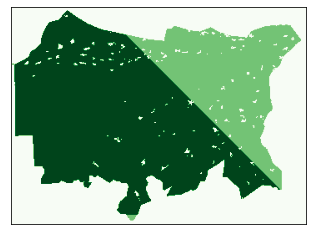

Pixel selected: 70.66%


In [363]:
plot_strip(train_strip)

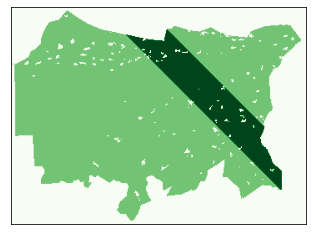

Pixel selected: 14.20%


In [364]:
plot_strip(valid_strip)

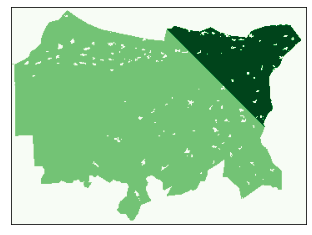

Pixel selected: 15.04%


In [365]:
plot_strip(test_strip)

### Now let's select the tiles within the given train-valid-test strips for nice alignment with the data loading

In [366]:
tiles_in_train = np.array([is_coord_below_diagonal(coord, diag1) 
                           for coord in labelled_dataset.tile_center_coords])
tiles_in_valid = np.array([is_coord_above_diagonal(coord, diag1) and is_coord_below_diagonal(coord, diag2) 
                           for coord in labelled_dataset.tile_center_coords])
tiles_in_test = np.array([is_coord_above_diagonal(coord, diag2) 
                          for coord in labelled_dataset.tile_center_coords])
ntiles = len(labelled_dataset.tile_center_coords)

train_tile_frac = np.sum(tiles_in_train) / ntiles
valid_tile_frac = np.sum(tiles_in_valid) / ntiles
test_tile_frac = np.sum(tiles_in_test) / ntiles

print(f"Tiles in train: {np.sum(tiles_in_train)} ({train_tile_frac*100:.2f} %)")
print(f"Tiles in valid: {np.sum(tiles_in_valid)} ({valid_tile_frac*100:.2f} % )")
print(f"Tiles in test: {np.sum(tiles_in_test)} ({test_tile_frac*100:.2f} %)")

Tiles in train: 701 (71.31 %)
Tiles in valid: 132 (13.43 % )
Tiles in test: 150 (15.26 %)


In [367]:
def create_mask_form_tile_centers(tile_center_coords, tile_size, target_shape):
    mask = np.zeros(target_shape, dtype=bool)
    
    for row_center, col_center in tile_center_coords:

        row_min = row_center - tile_size//2
        row_max = row_center + tile_size//2
        col_min = col_center - tile_size//2
        col_max = col_center + tile_size//2

        mask[row_min:row_max+1, col_min:col_max+1] = True
        
    return mask

In [368]:
train_mask = create_mask_form_tile_centers(labelled_dataset.tile_center_coords[tiles_in_train],
                                           tile_size = tile_size,
                                           target_shape = label_mask.shape)

valid_mask = create_mask_form_tile_centers(labelled_dataset.tile_center_coords[tiles_in_valid],
                                           tile_size = tile_size,
                                           target_shape = label_mask.shape)

test_mask = create_mask_form_tile_centers(labelled_dataset.tile_center_coords[tiles_in_test],
                                           tile_size = tile_size,
                                           target_shape = label_mask.shape)

In [370]:
def mask(arr, downsample=128):
    return np.ma.masked_where(arr[::downsample, ::downsample] == False, arr[::downsample, ::downsample])

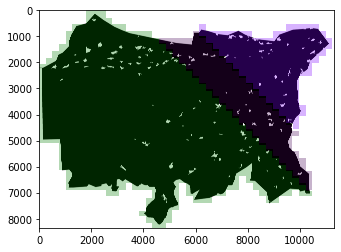

In [371]:
plt.imshow(label_mask, cmap="Greys")
plt.imshow(np.ma.masked_where(train_mask == False, train_mask*3), cmap="ocean", alpha=0.3)
plt.imshow(np.ma.masked_where(valid_mask == False, valid_mask*3), cmap="viridis", alpha=0.3)
plt.imshow(np.ma.masked_where(test_mask == False, test_mask*3), cmap="rainbow", alpha=0.3)

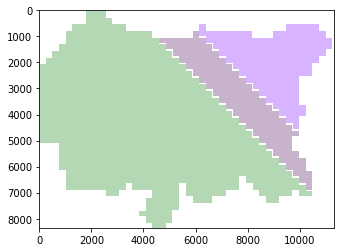

In [373]:
plt.imshow(np.ma.masked_where(train_mask == False, train_mask*3), cmap="ocean", alpha=0.3)
plt.imshow(np.ma.masked_where(valid_mask == False, valid_mask*3), cmap="viridis", alpha=0.3)
plt.imshow(np.ma.masked_where(test_mask == False, test_mask*3), cmap="rainbow", alpha=0.3)

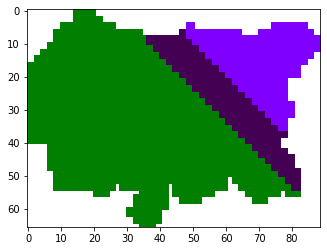

In [374]:
plt.imshow(mask(train_mask, 128), cmap="ocean")
plt.imshow(mask(valid_mask, 128), cmap="viridis")
plt.imshow(mask(test_mask, 128), cmap="rainbow")

In [375]:
train_mask2 = train_strip == 2
valid_mask2 = valid_strip == 2
test_mask2 = test_strip == 2

train_labels2 = copy.deepcopy(label_array.data.squeeze())
train_labels2[~train_mask2] = 0

valid_labels2 = copy.deepcopy(label_array.data.squeeze())
valid_labels2[~valid_mask2] = 0

test_labels2 = copy.deepcopy(label_array.data.squeeze())
test_labels2[~test_mask2] = 0

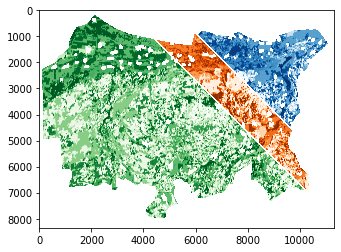

In [395]:
plt.imshow(mask(train_labels2, downsample=1), cmap="Greens")
plt.imshow(mask(valid_labels2, downsample=1), cmap="Oranges")
plt.imshow(mask(test_labels2, downsample=1), cmap="Blues")

In [377]:
train_labels = copy.deepcopy(label_array.data.squeeze())
train_labels[~train_mask] = 0

valid_labels = copy.deepcopy(label_array.data.squeeze())
valid_labels[~valid_mask] = 0

test_labels = copy.deepcopy(label_array.data.squeeze())
test_labels[~test_mask] = 0

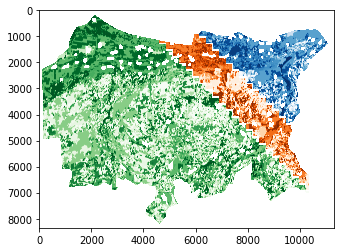

In [378]:
plt.imshow(mask(train_labels, downsample=None), cmap="Greens")
plt.imshow(mask(valid_labels, downsample=None), cmap="Oranges")
plt.imshow(mask(test_labels, downsample=None), cmap="Blues")

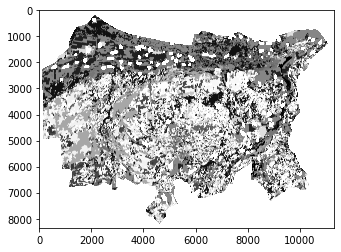

In [380]:
plt.imshow(mask(label_array.data.squeeze(), downsample=None), cmap="Greys")

## Write label masks to raster file

In [386]:
template_path = GWS_DATA_DIR / "polesia_empty_10m_template.tif"
with rasterio.open(template_path) as raster_data:
    out_arr = raster_data.read(1)
    transform = raster_data.transform
    meta = raster_data.meta.copy()
    meta.update(compress="lzw")

label_files = {
    "train": train_labels,
    "valid": valid_labels,
    "test": test_labels
} 

label_files2 = {
    "train-tiled": train_labels2,
    "valid-tiled": valid_labels2,
    "test-tiled": test_labels2
} 
for label_dict in [label_files, label_files2]:
    for name, labels in label_dict.items():
        save_path = GWS_DATA_DIR / f"polesia_labels_10m_{name}.tif"
        with rasterio.open(save_path, "w+", **meta) as out:
            out.write_band(1, labels)
            save_path.chmod(0o664)

# Misc

In [306]:
skip_diag = np.sort(np.vstack((make_horizontal(256*13, label_mask.shape), make_vertical(256*13, label_mask.shape))), axis=0)

In [283]:
def next_col(row, col, row_step, col_step):
    if row == 0: 
        return col
    elif row % row_step == 0:
        return col + col_step
    else:
        return col
    
def next_row(row, col, row_step, col_step):
    if col == 0:
        return row
    elif col % col_step == 0:
        return row + row_step
    else:
        return row
    
def make_vertical(col, shape, row_step=256, col_step=256):
    vertical = []
    for row in range(shape[0]):
        if col != next_col(row, col, row_step, col_step):
            col = next_col(row, col, row_step, col_step)
        vertical.append((row, col))
    return np.array(vertical)

def make_horizontal(col, shape, row_step=256, col_step=256):
    horizontal = []
    row = 0
    for col in range(shape[1]):
        if row != next_row(row,col,row_step, col_step):
            row = next_row(row,col,row_step, col_step)
        if row > 0: horizontal.append((row, col))
    return np.array(horizontal)